# Bad Apple!! - but it's an AI Image Generator

In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

In [ ]:
class Conv_Decoder(nn.Module):
    def __init__(self, latent_dim=256, num_classes=6572):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # FC layer for feature mapping
        self.fc = nn.Linear(num_classes, latent_dim * 3 * 4)

        # Deconvolution layers
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(256, 100, 
                               kernel_size=5, stride=5, padding=0),
            nn.BatchNorm2d(100),
            nn.ReLU()
        )
        
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(100, 100, 
                               kernel_size=3, stride=3, padding=0),
            nn.BatchNorm2d(100),
            nn.ReLU()
        )
        
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(100, 100, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(100),
            nn.ReLU()
        )
        
        self.deconv_block4 = nn.Sequential(
            nn.ConvTranspose2d(100, 100,
                               kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(100),
            nn.ReLU()
        )

        self.deconv_block5 = nn.Sequential(
            nn.ConvTranspose2d(100, 1,
                               kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # First convolution
        x = nn.functional.one_hot(x, num_classes=self.num_classes).float()
        x = self.fc(x)
        x = x.view(-1, self.latent_dim, 3, 4)
        
        x1 = self.deconv_block1(x)
        x2 = self.deconv_block2(x1)
        x2 = x2 + torch.sum(x)/12  # skip connection
        
        x3 = self.deconv_block3(x2)
        x4 = self.deconv_block4(x3)
        x4 = x4 + torch.sum(x)/12 # skip connection
        
        x5 = self.deconv_block5(x4)
        output = x5.view(-1, 180, 240)
        
        return output

In [ ]:
model = torch.load('models/Conv_Decoder_Clean.pkl', weights_only=False, map_location=device)

In [ ]:
step_size = 1

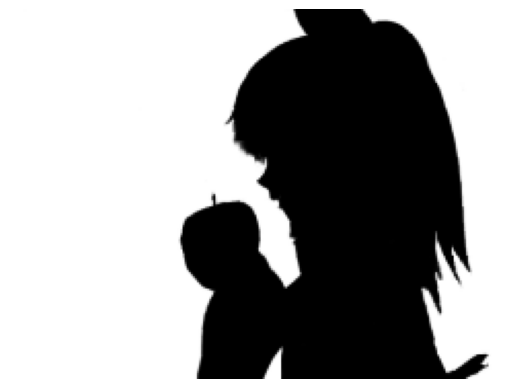

In [39]:
for i in range(0, 6572, step_size):
    with torch.no_grad():
        frame_image = model.forward(torch.tensor(i).to(device))[0]
        frame_image = frame_image * 255

    frame_image = frame_image.cpu().numpy()
    plt.imshow(frame_image, cmap="gray")
    plt.axis('off')
    
    clear_output(wait=True)  # Clear previous output
    display(plt.gcf())  # Display current figure
    plt.close()